In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix
import loess
from statsmodels.nonparametric.smoothers_lowess import lowess

In [4]:
data = pd.read_csv('data/Wage.csv', index_col=0).reset_index(drop=True)
data

year  age            maritl      race        education  \
0     2006   18  1. Never Married  1. White     1. < HS Grad   
1     2004   24  1. Never Married  1. White  4. College Grad   
2     2003   45        2. Married  1. White  3. Some College   
3     2003   43        2. Married  3. Asian  4. College Grad   
4     2005   50       4. Divorced  1. White       2. HS Grad   
...    ...  ...               ...       ...              ...   
2995  2008   44        2. Married  1. White  3. Some College   
2996  2007   30        2. Married  1. White       2. HS Grad   
2997  2005   27        2. Married  2. Black     1. < HS Grad   
2998  2005   27  1. Never Married  1. White  3. Some College   
2999  2009   55      5. Separated  1. White       2. HS Grad   

                  region        jobclass          health health_ins   logwage  \
0     2. Middle Atlantic   1. Industrial       1. <=Good      2. No  4.318063   
1     2. Middle Atlantic  2. Information  2. >=Very Good      2. No  4.255273   
2     2. Middle Atlantic   1. Industrial       1. <=Good     1. Yes  4.875061   
3     2. Middle Atlantic  2. Information  2. >=Very Good     1. Yes  5.041393   
4     2. Middle Atlantic  2. Information       1. <=Good     1. Yes  4.318063   
...                  ...             ...             ...        ...       ...   
2995  2. Middle Atlantic   1. Industrial  2. >=Very Good     1. Yes  5.041393   
2996  2. Middle Atlantic   1. Industrial  2. >=Very Good      2. No  4.602060   
2997  2. Middle Atlantic   1. Industrial       1. <=Good      2. No  4.193125   
2998  2. Middle Atlantic   1. Industrial  2. >=Very Good     1. Yes  4.477121   
2999  2. Middle Atlantic   1. Industrial       1. <=Good     1. Yes  4.505150   

            wage  
0      75.043154  
1      70.476020  
2     130.982177  
3     154.685293  
4      75.043154  
...          ...  
2995  154.685293  
2996   99.689464  
2997   66.229408  
2998   87.981033  
2999   90.481913  

[3000 rows x 11 columns]

In [5]:
x = data['age']
X = x.values.reshape(-1,1)
y = data['wage']

## Polynominal Regression

In [6]:
X4 = PolynomialFeatures(4).fit_transform(X)
poly_model = sm.GLS(y, X4).fit()
print(poly_model.summary())

                            GLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            GLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Thu, 22 Oct 2020   Prob (F-statistic):           2.77e-57
Time:                        22:34:29   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -184.1542     60.040     -3.067      0.0

In [7]:
# Create dummy for wage > 250
y_dummy = np.where(y>250, True, False)

# Create model for y_dummy
clf_model = sm.GLM(y_dummy, X4, family=sm.families.Binomial()).fit()

In [8]:
# Calculate number for ploting lines in charts
x_range = np.arange(X.min(), X.max()+1).reshape(-1,1)
x_4_visual = PolynomialFeatures(4).fit_transform(x_range)

# y_visual for line wage and probability
y_visual_poly = poly_model.predict(x_4_visual)
y_visual_dummy = clf_model.predict(x_4_visual)

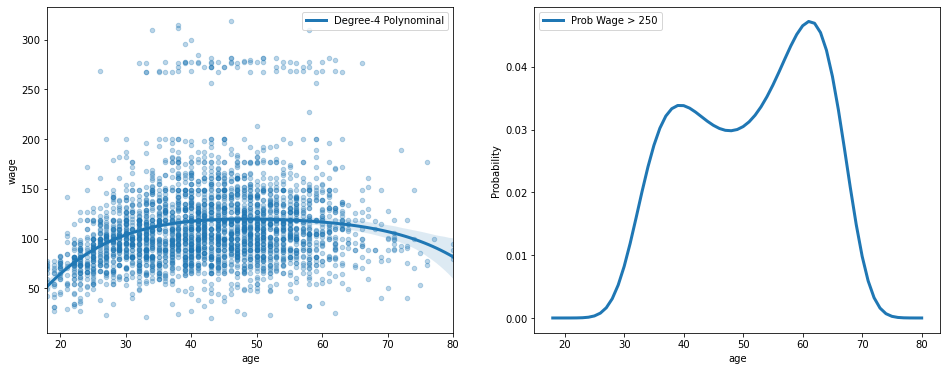

In [9]:
# Visualize model
plt.figure(figsize=(16,6))

# Plot 1: Scatter plot and polynominal regression line
plot_1 = plt.subplot(1,2,1)
# sb.scatterplot(data=data, x='age', y='wage', alpha=0.3)
# plt.plot(x_range, y_visual, linewidth=3, label='Degree-4 Polynominal')
sb.regplot(data=data, x='age', y='wage', order=4, scatter_kws={"s": 20, 'alpha': 0.3}, line_kws={'linewidth': 3, 'label': 'Degree-4 Polynominal'})
plt.legend()

# Plot 2: Probability wage > 250 along with changes on age
plot_2 = plt.subplot(1,2,2)
plt.plot(x_range, y_visual_dummy, linewidth=3, label='Prob Wage > 250')
plt.xlabel('age')
plt.ylabel('Probability')
plt.legend()

plt.show()

## ANOVA to find best degree of Polynominal Regression

In [10]:
# Process ANOVA test
X1 = PolynomialFeatures(1).fit_transform(X)
X2 = PolynomialFeatures(2).fit_transform(X)
X3 = PolynomialFeatures(3).fit_transform(X)
X4 = PolynomialFeatures(4).fit_transform(X)
X5 = PolynomialFeatures(5).fit_transform(X)

# Fit multiple models with difference degree
model_1 = sm.GLS(y, X1).fit()
model_2 = sm.GLS(y, X2).fit()
model_3 = sm.GLS(y, X3).fit()
model_4 = sm.GLS(y, X4).fit()
model_5 = sm.GLS(y, X5).fit()

# Perform anova test
anova_test = sm.stats.anova_lm(model_1, model_2, model_3, model_4, model_5)
print(anova_test)

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.593107  2.363850e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.888756  1.679202e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.809813  5.104620e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.804976  3.696820e-01


In [11]:
# Result show that model 5 (index 4) is not good, model 4 (index 3 is good), model < 4 seem not sufficient

In [12]:
# We also can see p value X^5 in model_5.summary is 0.37 (too high)
print(model_5.summary())

                            GLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.087
Model:                            GLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     56.71
Date:                Thu, 22 Oct 2020   Prob (F-statistic):           1.67e-56
Time:                        22:34:31   Log-Likelihood:                -15314.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2994   BIC:                         3.068e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -49.7046    161.435     -0.308      0.7

## Step Constant Function

In [13]:
# Cut X in some bins to plot step constant method
df_cut, bins = pd.cut(data['age'], 4, retbins=True, right=True)
df_cut.value_counts(sort=False)

(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: age, dtype: int64

In [14]:
df_steps = pd.concat([data['age'], df_cut, data['wage']], keys = ['age','age_cuts','wage'], axis = 1)

# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_steps['age_cuts'], drop_first=True)

# Statsmodels requires explicit adding of a constant (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)
df_steps_dummies

const  (33.5, 49.0]  (49.0, 64.5]  (64.5, 80.0]
0       1.0             0             0             0
1       1.0             0             0             0
2       1.0             1             0             0
3       1.0             1             0             0
4       1.0             0             1             0
...     ...           ...           ...           ...
2995    1.0             1             0             0
2996    1.0             0             0             0
2997    1.0             0             0             0
2998    1.0             0             0             0
2999    1.0             0             1             0

[3000 rows x 4 columns]

In [15]:
# Create step model
poly_step_model = sm.GLM(y, df_steps_dummies).fit()
print(poly_step_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2996
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          1634.1
Method:                          IRLS   Log-Likelihood:                -15353.
Date:                Thu, 22 Oct 2020   Deviance:                   4.8957e+06
Time:                        22:34:31   Pearson chi2:                 4.90e+06
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           94.1584      1.476     63.790   

In [16]:
# Create x_range follow bins
x_range_bins = np.digitize(x_range.ravel(), bins, right=True)
x_range_bins = pd.get_dummies(x_range_bins, drop_first=True)
x_range_bins = sm.add_constant(x_range_bins)

# y_visual_step
y_visual_step = poly_step_model.predict(x_range_bins)

# y_visual_dummy_step
clf_step_model = sm.GLM(y_dummy, df_steps_dummies, family=sm.families.Binomial()).fit()
y_visual_dummy_step = clf_step_model.predict(x_range_bins)

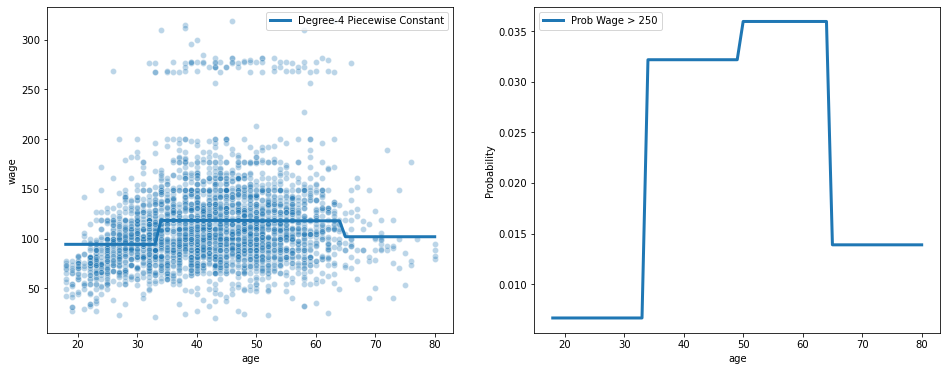

In [17]:
# Plot 2 charts
plt.figure(figsize=(16,6))
plot_1 = plt.subplot(1,2,1)
sb.scatterplot(data=data, x='age', y='wage', alpha=0.3)
plt.plot(x_range, y_visual_step, linewidth=3, label='Degree-4 Piecewise Constant')
plt.legend()

plot_2 = plt.subplot(1,2,2)
plt.plot(x_range, y_visual_dummy_step, linewidth=3, label='Prob Wage > 250')
plt.xlabel('age')
plt.ylabel('Probability')
plt.legend()

plt.show()

## Splines

In [18]:
# Specifying 3 knots
transformed_x1 = dmatrix('bs(data.age, knots=(25,40,60), degree=3, include_intercept=False)', {'data.age': data['age']}, return_type='dataframe')
transformed_x1

Intercept  \
0           1.0   
1           1.0   
2           1.0   
3           1.0   
4           1.0   
...         ...   
2995        1.0   
2996        1.0   
2997        1.0   
2998        1.0   
2999        1.0   

      bs(data.age, knots=(25, 40, 60), degree=3, include_intercept=False)[0]  \
0                                              0.000000                        
1                                              0.559911                        
2                                              0.000000                        
3                                              0.000000                        
4                                              0.000000                        
...                                                 ...                        
2995                                           0.000000                        
2996                                           0.137741                        
2997                                           0.302617                        
2998                                           0.302617                        
2999                                           0.000000                        

      bs(data.age, knots=(25, 40, 60), degree=3, include_intercept=False)[1]  \
0                                              0.000000                        
1                                              0.403778                        
2                                              0.114796                        
3                                              0.167109                        
4                                              0.034014                        
...                                                 ...                        
2995                                           0.139320                        
2996                                           0.629111                        
2997                                           0.586851                        
2998                                           0.586851                        
2999                                           0.004252                        

      bs(data.age, knots=(25, 40, 60), degree=3, include_intercept=False)[2]  \
0                                              0.000000                        
1                                              0.033395                        
2                                              0.618564                        
3                                              0.633167                        
4                                              0.508194                        
...                                                 ...                        
2995                                           0.628472                        
2996                                           0.228819                        
2997                                           0.110255                        
2998                                           0.110255                        
2999                                           0.341933                        

      bs(data.age, knots=(25, 40, 60), degree=3, include_intercept=False)[3]  \
0                                              0.000000                        
1                                              0.000000                        
2                                              0.262733                        
3                                              0.198880                        
4                                              0.426542                        
...                                                 ...                        
2995                                           0.230208                        
2996                                           0.004329                        
2997                                           0.000277                        
2998                                           0.000277                        
2999          

In [19]:
# Create model spline
spline_model1 = sm.GLM(y, transformed_x1).fit()
print(spline_model1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2993
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                          1594.0
Method:                          IRLS   Log-Likelihood:                -15314.
Date:                Thu, 22 Oct 2020   Deviance:                   4.7708e+06
Time:                        22:34:32   Pearson chi2:                 4.77e+06
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

In [27]:
# Create function to visualize result of Splines
def display_splines(model, transformed_x1, X, y):
    idx = np.argsort(X.flatten())
    y_visual = model.predict(transformed_x1)
    plt.figure(figsize=(8,6))
    plt.scatter(x=X, y=y, alpha=0.3)
    plt.plot(X[idx], y_visual[idx], color='darkblue', linewidth=3)
    plt.show()

In [41]:
def display_splines_in_multiple(model, transformed_x1, X, y, label):
    idx = np.argsort(X.flatten())
    y_visual = model.predict(transformed_x1)
    plt.plot(X[idx], y_visual[idx], linewidth=3, label=label)

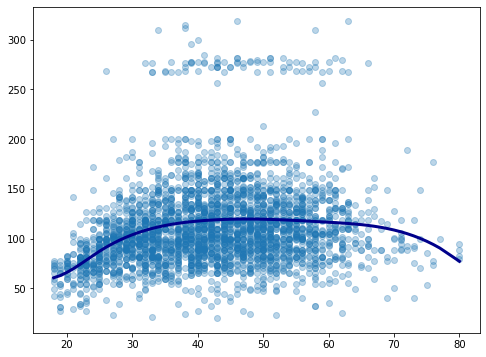

In [28]:
display_splines(spline_model1, transformed_x1, X, y)

In [30]:
# Specifying 6 degrees of freedom
transformed_x2 = dmatrix('bs(data.age, df=6, include_intercept=False)', {'data.age': data['age']}, return_type='dataframe')
transformed_x2

Intercept  bs(data.age, df=6, include_intercept=False)[0]  \
0           1.0                                        0.000000   
1           1.0                                        0.537145   
2           1.0                                        0.000000   
3           1.0                                        0.000000   
4           1.0                                        0.000000   
...         ...                                             ...   
2995        1.0                                        0.000000   
2996        1.0                                        0.324371   
2997        1.0                                        0.481232   
2998        1.0                                        0.481232   
2999        1.0                                        0.000000   

      bs(data.age, df=6, include_intercept=False)[1]  \
0                                           0.000000   
1                                           0.208308   
2                                           0.042161   
3                                           0.099937   
4                                           0.000195   
...                                              ...   
2995                                        0.066950   
2996                                        0.523603   
2997                                        0.381609   
2998                                        0.381609   
2999                                        0.000000   

      bs(data.age, df=6, include_intercept=False)[2]  \
0                                           0.000000   
1                                           0.017316   
2                                           0.751086   
3                                           0.780172   
4                                           0.529332   
...                                              ...   
2995                                        0.772273   
2996                                        0.138528   
2997                                        0.058442   
2998                                        0.058442   
2999                                        0.306568   

      bs(data.age, df=6, include_intercept=False)[3]  \
0                                           0.000000   
1                                           0.000000   
2                                           0.204676   
3                                           0.119815   
4                                           0.431076   
...                                              ...   
2995                                        0.160162   
2996                                        0.000000   
2997                                        0.000000   
2998                                        0.000000   
2999                                        0.532836   

      bs(data.age, df=6, include_intercept=False)[4]  \
0                                           0.000000   
1                                           0.000000   
2                                           0.002078   
3                                           0.000077   
4                                           0.039397   
...                                              ...   
2995                                        0.000616   
2996                                        0.000000   
2997                                        0.000000   
2998                                        0.000000   
2999                                        0.157972   

      bs(data.age, df=6, include_intercept=False)[5]  
0                                           0.000000  
1                                           0.000000  
2                                           0.000000  
3                                           0.000000  
4                                           0.000000  
...                                              ...  
2995                                        0.000000  
2996                                        0.000000  
2997          

In [31]:
# Create model spline
spline_model2 = sm.GLM(y, transformed_x2).fit()
spline_model2.params

Intercept                                         56.313841
bs(data.age, df=6, include_intercept=False)[0]    27.824002
bs(data.age, df=6, include_intercept=False)[1]    54.062546
bs(data.age, df=6, include_intercept=False)[2]    65.828391
bs(data.age, df=6, include_intercept=False)[3]    55.812734
bs(data.age, df=6, include_intercept=False)[4]    72.131473
bs(data.age, df=6, include_intercept=False)[5]    14.750876
dtype: float64

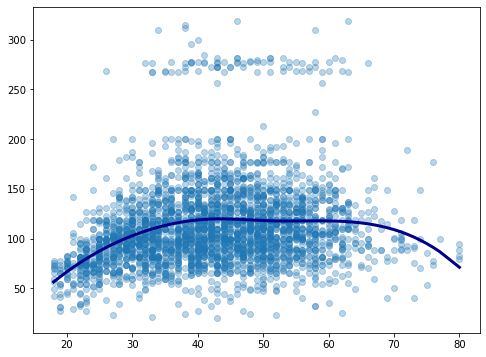

In [32]:
display_splines(spline_model2, transformed_x2, X, y)

In [33]:
# Specifying 4 degrees of freedom with cr instead bs
transformed_x3 = dmatrix('cr(data.age, df=4)', {'data.age': data['age']}, return_type='dataframe')
transformed_x3

Intercept  cr(data.age, df=4)[0]  cr(data.age, df=4)[1]  \
0           1.0               1.000000               0.000000   
1           1.0               0.627430               0.462418   
2           1.0              -0.080345               0.756695   
3           1.0              -0.072389               0.856210   
4           1.0              -0.065013               0.454076   
...         ...                    ...                    ...   
2995        1.0              -0.077620               0.808722   
2996        1.0               0.297924               0.828456   
2997        1.0               0.454603               0.663508   
2998        1.0               0.454603               0.663508   
2999        1.0              -0.024047               0.147660   

      cr(data.age, df=4)[2]  cr(data.age, df=4)[3]  
0                  0.000000               0.000000  
1                 -0.105556               0.015708  
2                  0.372737              -0.049087  
3                  0.251241              -0.035062  
4                  0.679982              -0.069045  
...                     ...                    ...  
2995               0.311189              -0.042290  
2996              -0.148474               0.022094  
2997              -0.138759               0.020649  
2998              -0.138759               0.020649  
2999               0.922238              -0.045850  

[3000 rows x 5 columns]

In [34]:
# Create model spline
spline_model3 = sm.GLM(y, transformed_x3).fit()
spline_model3.params

Intercept                79.642095
cr(data.age, df=4)[0]   -14.667784
cr(data.age, df=4)[1]    36.811142
cr(data.age, df=4)[2]    35.934874
cr(data.age, df=4)[3]    21.563863
dtype: float64

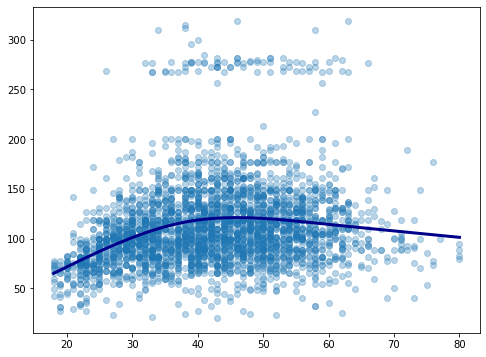

In [35]:
display_splines(spline_model3, transformed_x3, X, y)

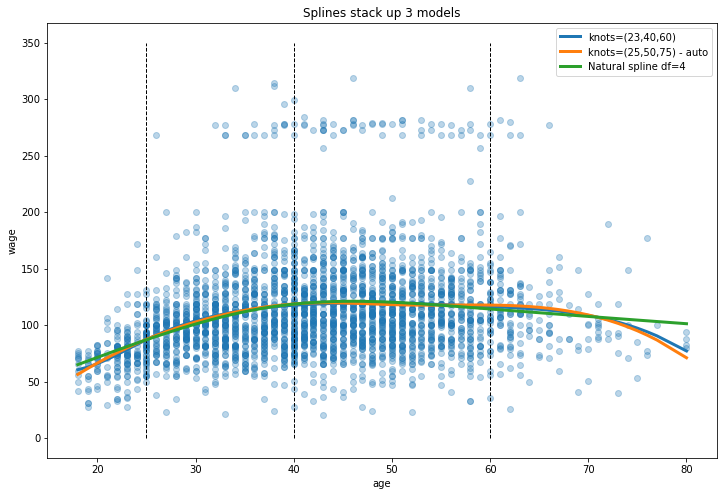

In [43]:
# Stack up all 3 model
plt.figure(figsize=(12,8))
plt.scatter(x=X, y=y, alpha=0.3)
display_splines_in_multiple(spline_model1, transformed_x1, X, y, 'knots=(23,40,60)')
display_splines_in_multiple(spline_model2, transformed_x2, X, y, 'knots=(25,50,75) - auto')
display_splines_in_multiple(spline_model3, transformed_x3, X, y, 'Natural spline df=4')
[plt.vlines(i , 0, 350, linestyles='dashed', lw=1) for i in [25,40,60]]
plt.legend()
plt.title('Splines stack up 3 models')
plt.xlabel('age')
plt.ylabel('wage')
plt.show()

## Local Regression

In [36]:
local_regr = lowess(y, x, frac=0.2, return_sorted=True)
local_regr

array([[18.        , 58.4833787 ],
       [18.        , 58.4833787 ],
       [18.        , 58.4833787 ],
       ...,
       [80.        , 83.84164611],
       [80.        , 83.84164611],
       [80.        , 83.84164611]])

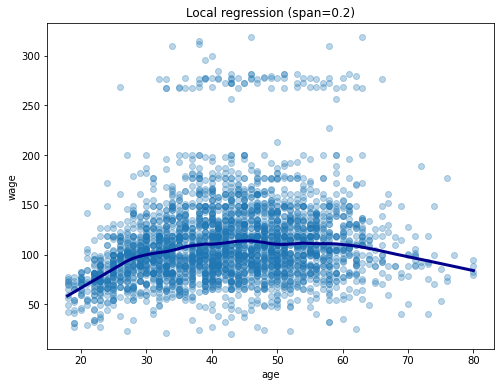

In [38]:
plt.figure(figsize=(8,6))
plt.scatter(x=X, y=y, alpha=0.3)
plt.plot(local_regr[:,0], local_regr[:,1], color='darkblue', linewidth=3)
plt.title('Local regression (span=0.2)')
plt.xlabel('age')
plt.ylabel('wage')
plt.show()

In [41]:
local_regr2 = lowess(y, x, frac=0.5, return_sorted=True)
local_regr2

array([[18.        , 66.16357852],
       [18.        , 66.16357852],
       [18.        , 66.16357852],
       ...,
       [80.        , 93.68232366],
       [80.        , 93.68232366],
       [80.        , 93.68232366]])

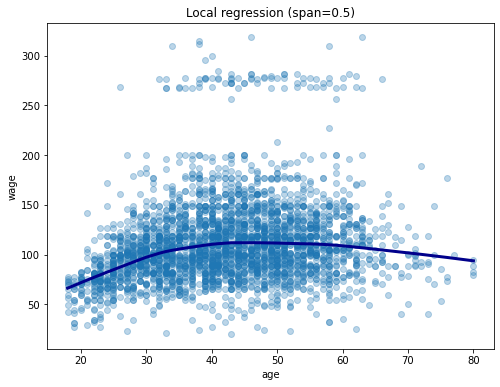

In [42]:
plt.figure(figsize=(8,6))
plt.scatter(x=X, y=y, alpha=0.3)
plt.plot(local_regr2[:,0], local_regr2[:,1], color='darkblue', linewidth=3)
plt.title('Local regression (span=0.5)')
plt.xlabel('age')
plt.ylabel('wage')
plt.show()

In [43]:
local_regr3 = lowess(y, x, frac=0.9, return_sorted=True)
local_regr3

array([[ 18.        ,  77.50602205],
       [ 18.        ,  77.50602205],
       [ 18.        ,  77.50602205],
       ...,
       [ 80.        , 103.43992868],
       [ 80.        , 103.43992868],
       [ 80.        , 103.43992868]])

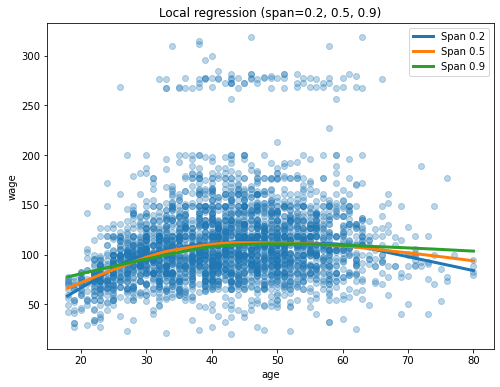

In [46]:
plt.figure(figsize=(8,6))
plt.scatter(x=X, y=y, alpha=0.3)
plt.plot(local_regr[:,0], local_regr[:,1], linewidth=3, label='Span 0.2')
plt.plot(local_regr2[:,0], local_regr2[:,1], linewidth=3, label='Span 0.5')
plt.plot(local_regr3[:,0], local_regr3[:,1], linewidth=3, label='Span 0.9')
plt.title('Local regression (span=0.2, 0.5, 0.9)')
plt.xlabel('age')
plt.ylabel('wage')
plt.legend()
plt.show()

## Generalized Additive Models

In [79]:
# Create A big matrix have year, age natural splines, education dummy variable
GAM_matrix = dmatrix("cr(year, df=4, constraints='center') + cr(age, df=5, constraints='center') + education", data={'year': data['year'], 'age': data['age'], 'education': data['education']}, return_type='dataframe')

# Fit model
gam_model = sm.OLS(y, GAM_matrix).fit()
print(gam_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     95.22
Date:                Wed, 21 Oct 2020   Prob (F-statistic):          1.55e-213
Time:                        22:26:27   Log-Likelihood:                -14930.
No. Observations:                3000   AIC:                         2.989e+04
Df Residuals:                    2986   BIC:                         2.997e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [105]:
# Get year coef
year_coef = gam_model.params[5:9]
age_coef = gam_model.params[9:]
edu_coef = gam_model.params[1:5]

# Get columns in GAM1_matrix for year basis function
year_basis = GAM_matrix.iloc[:,5:9]
age_basis = GAM_matrix.iloc[:,9:]
edu_basis = GAM_matrix.iloc[:,1:5]

# F1(year) values, F2(age), F3(education)
year_f1 = np.dot(year_basis, year_coef)
age_f2 = np.dot(age_basis, age_coef)
edu_f3 = np.dot(edu_basis, edu_coef)

# Get order x axis
order_year = np.argsort(data['year'].values)
order_age = np.argsort(data['age'].values)
order_edu = np.argsort(data['education'].values)

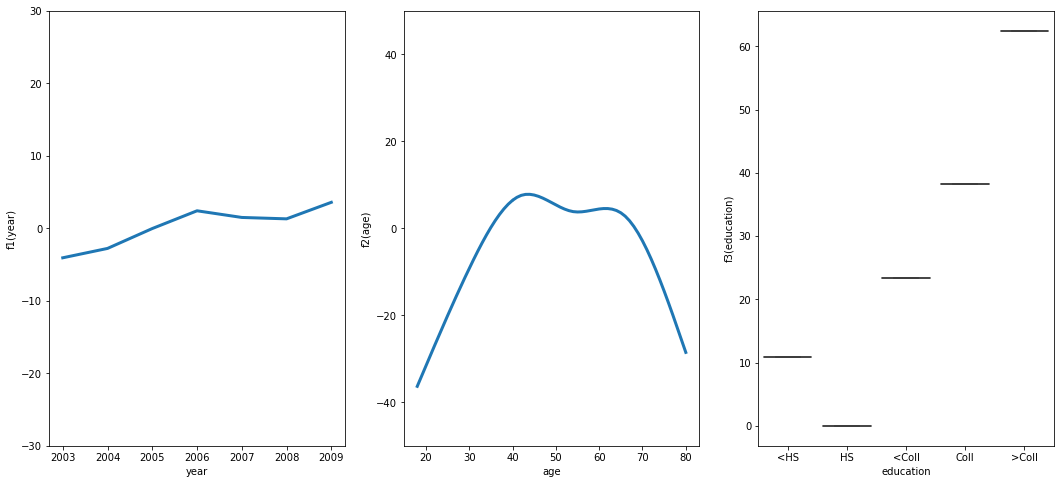

In [169]:
plt.figure(figsize=(18,8))

# Plot f1(year) function
plt.subplot(1,3,1)
plt.plot(data['year'][order_year], year_f1[order_year], linewidth=3, label='f1(year)')
plt.xlabel('year')
plt.ylabel('f1(year)')
plt.ylim([-30,30])

# Plot f2(age) function
plt.subplot(1,3,2)
plt.plot(data['age'][order_age], age_f2[order_age], linewidth=3, label='f2(age)')
plt.xlabel('age')
plt.ylabel('f2(age)')
plt.ylim([-50,50])

plt.subplot(1,3,3)
sb.boxplot(x=data['education'][order_edu], y=edu_f3[order_edu])
plt.xticks([0, 1, 2, 3, 4], ['<HS', 'HS', '<Coll', 'Coll', '>Coll'])
plt.ylabel('f3(education)')

plt.show()

In [116]:
# Model 1
matrix_1 = dmatrix("cr(age, df=5, constraints='center') + education", data={'age': data['age'], 'education': data['education']}, return_type='dataframe')

gam_1 = sm.OLS(y, matrix_1).fit()

# Model 2
matrix_2 = dmatrix("year + cr(age, df=5, constraints='center') + education", data={'year': data['year'], 'age': data['age'], 'education': data['education']}, return_type='dataframe')

gam_2 = sm.OLS(y, matrix_2).fit()

# Model 3
matrix_3 = dmatrix("cr(year, df=4, constraints='center') + cr(age, df=5, constraints='center') + education", data={'year': data['year'], 'age': data['age'], 'education': data['education']}, return_type='dataframe')

gam_3 = sm.OLS(y, matrix_3).fit()

# ANOVA test GAM models
anova = sm.stats.anova_lm(gam_1, gam_2, gam_3)
print(anova)

   df_resid           ssr  df_diff       ss_diff          F    Pr(>F)
0    2990.0  3.712549e+06      0.0           NaN        NaN       NaN
1    2989.0  3.695015e+06      1.0  17534.011180  14.182511  0.000169
2    2986.0  3.691628e+06      3.0   3386.677223   0.913113  0.433717


In [117]:
print(gam_3.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     95.22
Date:                Wed, 21 Oct 2020   Prob (F-statistic):          1.55e-213
Time:                        23:02:08   Log-Likelihood:                -14930.
No. Observations:                3000   AIC:                         2.989e+04
Df Residuals:                    2986   BIC:                         2.997e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

## Logistic Regression GAM

In [118]:
# Fit model with y_dummy
gam_model_logis = sm.GLM(y_dummy, GAM_matrix, family=sm.families.Binomial()).fit()
print(gam_model_logis.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2986
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -300.91
Date:                Wed, 21 Oct 2020   Deviance:                       601.81
Time:                        23:06:58   Pearson chi2:                 2.50e+03
No. Iterations:                    24                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [163]:
# Get year coef
year_coef_dummy = gam_model_logis.params[5:9]
age_coef_dummy = gam_model_logis.params[9:]
edu_coef_dummy = gam_model_logis.params[1:5]

# Get columns in GAM1_matrix for year basis function
year_basis_dummy = GAM_matrix.iloc[:,5:9]
age_basis_dummy = GAM_matrix.iloc[:,9:]
edu_basis_dummy = GAM_matrix.iloc[:,1:5]

# F1(year) values, F2(age), F3(education)
year_f1_dummy = np.dot(year_basis_dummy, year_coef_dummy)
age_f2_dummy = np.dot(age_basis_dummy, age_coef_dummy)
edu_f3_dummy = np.dot(edu_basis_dummy, edu_coef_dummy)

# Get order x axis
order_year = np.argsort(data['year'].values)
order_age= np.argsort(data['age'].values)

# Create dataframe for education & f3(edu)
edu_table = pd.DataFrame({'education': data['education'].values, 'f3': edu_f3_dummy})
edu_table_draw = edu_table[edu_table['education'] != '1. < HS Grad'].reset_index(drop=True)
order_edu = np.argsort(edu_table_draw['education'].values)

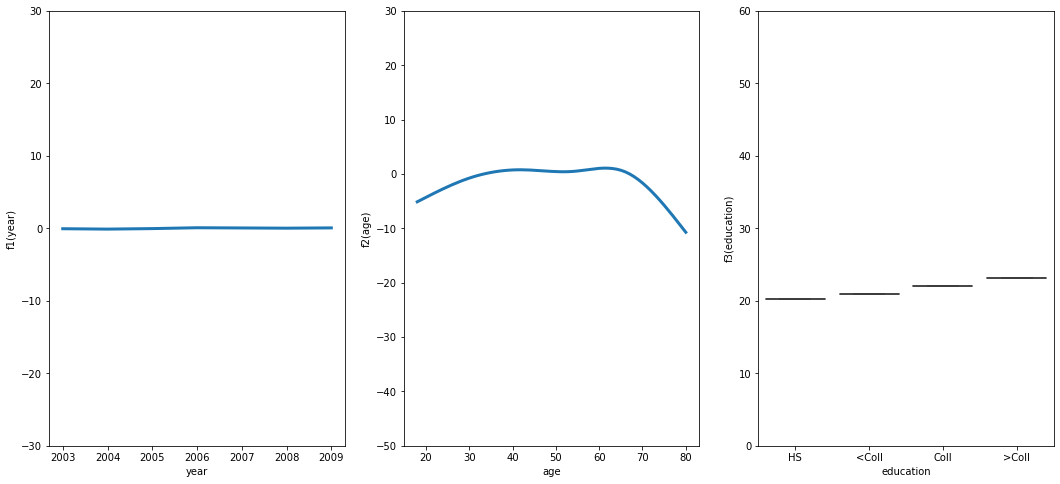

In [170]:
plt.figure(figsize=(18,8))

# Plot f1(year) function
plt.subplot(1,3,1)
plt.plot(data['year'][order_year], year_f1_dummy[order_year], linewidth=3, label='f1(year)')
plt.xlabel('year')
plt.ylabel('f1(year)')
plt.ylim([-30,30])

# Plot f2(age) function
plt.subplot(1,3,2)
plt.plot(data['age'][order_age], age_f2_dummy[order_age], linewidth=3, label='f2(age)')
plt.xlabel('age')
plt.ylabel('f2(age)')
plt.ylim([-50,30])

plt.subplot(1,3,3)
sb.boxplot(x=edu_table_draw['education'][order_edu], y=edu_table_draw['f3'][order_edu])
plt.xticks([0, 1, 2, 3], ['HS', '<Coll', 'Coll', '>Coll'])
plt.ylabel('f3(education)')
plt.ylim([0,60])

plt.show()